## Problem Set 06
### AST 8110, Fall 2022
##### Tyler Barna

In [1]:
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import time
#bigstart = time.time()


import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random
import skimage

from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from numpy.linalg import inv
from numpy.linalg import norm ## to calculate magnitude of vector

from tqdm import tqdm
from scipy import meshgrid
from scipy.stats import binned_statistic as binstat
from scipy.integrate import quad, dblquad ## to integrate
from scipy.signal import argrelextrema as extrema 

from skimage.draw import circle_perimeter as cp

#%matplotlib inline
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
#plt.rc("text", usetex=True)
#plt.rc("font", family="serif")

## Set Seed
random.seed(8110)

### Problem 1

Take $b=0.07$ and assume sources are evenly spaced at distances of $0.05$ and both $x$ and $y$ go from $0 \rightarrow 1$.

The foreground masses are singular isothermal spheres (SIS) located at

$$
\begin{align}
(0.44,0.44) \\
(0.51,0.51) \\
(0.58,0.58) 
\end{align}
$$

SIS equations are given by
$$
\begin{equation}
\Psi  = b \left[x^2 +y^2\right]^{1/2} = b R
\end{equation}
$$

$$
\begin{equation}
\kappa = \frac{b}{2R}
\end{equation}
$$

$$
\begin{equation}
\gamma_1 = \frac{b \left[y^2 - x^2\right]}{2R^3}
\end{equation}
$$

$$
\begin{equation}
\gamma_2 = \frac{b xy}{R^3}
\end{equation}
$$

For $R= \sqrt{x^2 + y^2}$

We know that the lensing potentials add linearly; from this, we can determine that $\gamma_1$ and $\gamma_2$ add linearly as well. We can also determine that $\kappa$ adds linearly.

To apply the transformation, I use the equation from the lecture:

$$
\begin{gather}
\begin{pmatrix} 
x_u \\
y_u
\end{pmatrix} 
\begin{pmatrix}
1 - g_1 & -g_2 \\
-g_2 & 1 + g_1
\end{pmatrix}^{-1}
=
\begin{pmatrix}
x_l \\
y_l
\end{pmatrix}
\end{gather}
$$
where the left hand side are the un-lensed coordinates multiplied by the reduced shear matrix and the right hand side are the lensed coordinates.

In [2]:
## create array of source positions
x = np.arange(0, 1.05, 0.05) ## so we actually have 21 sources
y = np.arange(0, 1.05, 0.05)
xx, yy = np.meshgrid(x, y)

## define the lens locations
lens_xy = np.array([[0.44, 0.44], [0.51,0.51], [0.58,0.58]])

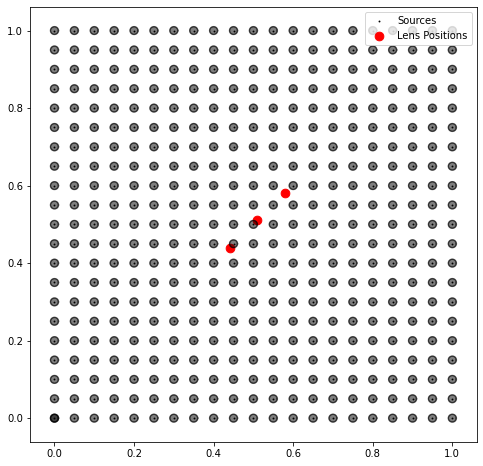

In [3]:
## plot the original source positions
fig, ax = plt.subplots(figsize=(8,8),facecolor="w")
ax.scatter(xx, yy,  color="k",s=0.8, label="Sources");
sr = 0.01 ## radius of each source

def plot_sources(x, y):
    circ = plt.Circle((x, y), sr, color="k", alpha=0.5, fill=True)
    ax.add_patch(circ)
    x1 =  sr * np.cos(np.linspace(0, 2*np.pi, 100))
    y1 =  sr * np.sin(np.linspace(0, 2*np.pi, 100))
    ax.plot(x+x1, y+y1, color="k", alpha=0.5)
    
ps = np.vectorize(plot_sources)
ps(xx,yy)
ax.scatter(lens_xy[:,0], lens_xy[:,1], color="r", s=75, label="Lens Positions");
ax.legend()
plt.show();

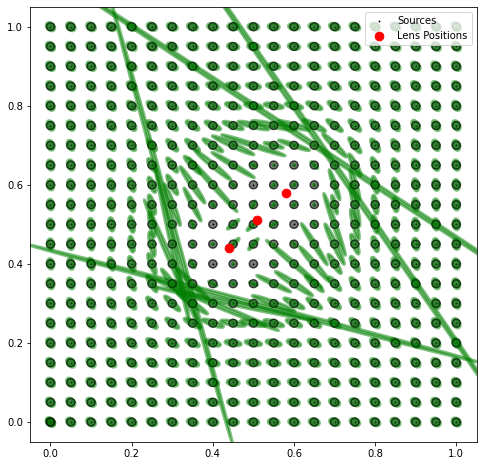

In [26]:
b = 0.07 
lens_xy = np.array([[0.44, 0.44], [0.51,0.51], [0.58,0.58]])


def R(source):
    """
    Calculates the distance R from the source to the lens and then sums over all lenses
    """
    xy = [np.array(source) - lens for lens in lens_xy]
    #xy = np.sum([np.array(source) - lens for lens in lens_xy],axis=0)
    radii = [norm(item) for item in xy]
    #radii = np.array([np.sum([norm(item) for item in xy])])
    #print(radii)
    return  radii

def gamma(source):
    """
    Calculates the gamma value at a given source position
    """
    xy = np.abs(source - lens_xy)
    #print(xy)
    gamma1 = [b* (xy[1]**2 - xy[0]**2)/(2* rad **3) for xy,rad in zip(xy,R(source))]
    gamma2 = [- b * xy[0] * xy[1] / (rad **3) for xy,rad in zip(xy,R(source))]
    return gamma1, gamma2

def kappa(source):
    """
    Calculates the kappa value at a given source position
    """
    kap = [b/(2*rad) for rad in R(source)] 
    return kap

def shear(source):
    gamma1, gamma2 = gamma(source)
    g1 = np.sum(gamma1) / (1 - np.sum(kappa(source)))
    g2 = np.sum(gamma2) / (1 - np.sum(kappa(source)))
    return g1, g2

def plot_shear(x, y):
    g1, g2 = shear([x,y])
    t = np.linspace(0, 2*np.pi, 100)
    source = np.array([sr * np.cos(t), sr * np.sin(t)])
    trans_matrix = np.array([[1-g1, -g2], 
                             [-g2, 1+g1]])
    image = np.zeros((2,source.shape[1]))

    for i in range(source.shape[1]):
        image[:,i] = np.dot(inv(trans_matrix),source[:,i])
    x1, y1 = x + image[0,:], y + image[1,:]
    ax.fill(x1, y1, color="g", alpha=0.5,lw=3)
plot_shear = np.vectorize(plot_shear)
   
fig, ax = plt.subplots(figsize=(8,8),facecolor="w")
ax.scatter(xx, yy,  color="k",s=0.8, label="Sources");
ps(xx,yy) ## plot the original source positions
plot_shear(xx,yy) ## plot the shear
ax.scatter(lens_xy[:,0], lens_xy[:,1], color="r", s=75, label="Lens Positions",zorder=1000); ## plot the lens positions
ax.set_xlim(-0.05,1.05); ax.set_ylim(-0.05,1.05)

ax.legend(loc="upper right")
plt.show();

### Problem 2

The intrinsic unlensed luminosity function (LF) is given by
$$
\begin{equation}
n_U (f) = \left( f^{s_1} + f^{s_2} \right)^{-1}
\end{equation}
$$
where $n_U (f)$ is the unlensed number density of sources with fluxes in a small interval around $f$, and $s_1$ and $s_2$ are the slopes of the faint and bright ends of the LF, respectively. 

Assume $s_1=0.3$ and $s_2=3.0$. The LF applies between $f=0.05$ and $f=10.0$.

The lens has a magnification probability of a Gaussian form:

$$
\begin{equation}
p\left(\mu\right) \text{d}\mu = \frac{1}{\sqrt{\pi \sigma_\mu^2}} \text{exp}\left(-\frac{(\mu - \mu_0)^2}{\sigma_\mu^2}\right) \text{d}\mu
\end{equation}
$$

The lensed LF is a convolution of the unlensed LF, $n_U (f)$ with magnification PDF, $p(\mu)$, and also includes the area dilution effect
$$
\begin{equation}
n_L (f) = \int \frac{n_U (f/\mu) p(\mu)}{\mu} \text{d}\mu
\end{equation}
$$


(a) $ \mu_0 = 2.5, \ \sigma_\mu = 0.5 $

(b) $ \mu_0 = 0.7, \ \sigma_\mu = 0.3 $

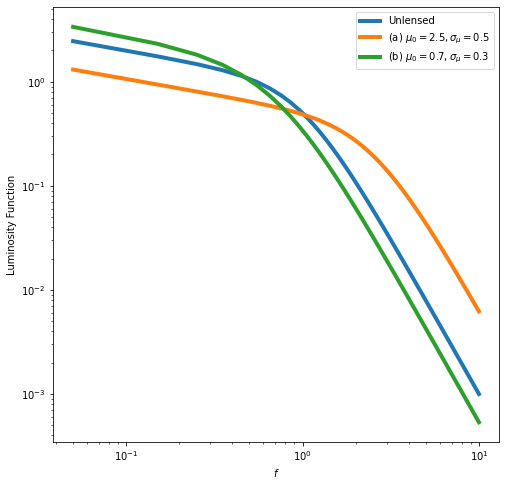

In [69]:
## values of f and mu_0 and sigma_mu values
f_range = np.linspace(0.05,10.0,100)
vars = np.array([[2.5,0.5],
                 [0.7,0.3]])
##s vals
s1, s2 = 0.3, 3.0

## define the unlensed luminosity function
def n_u(f):
    n = (f**s1 + f**s2)**(-1)
    return n

## define magnification probability
def p_mu(mu, mu_0, sig_mu):
    p = ( np.pi*sig_mu**2 )**(-1/2) * np.exp( - (mu - mu_0)**2 / sig_mu**2 )
    return p

## define the lensed luminosity function
def n_l(f, mu_0, sig_mu):
    integrand = lambda mu: (n_u(f/mu) * p_mu(mu, mu_0, sig_mu))/mu
    n = quad(integrand, 0, np.inf)[0]
    return n
n_l = np.vectorize(n_l)

## plot the results
fig, ax = plt.subplots(figsize=(8,8),facecolor="w")
ax.plot(f_range, n_u(f_range), lw=4, label="Unlensed")
labels = [r'(a) $\mu_0 = 2.5, \sigma_{\mu} = 0.5$', 
          r'(b) $\mu_0 = 0.7, \sigma_{\mu} = 0.3$']
for vals, label in zip(vars, labels):
    ax.plot(f_range, n_l(f_range, vals[0], vals[1]), lw=4, label=label)

ax.set_xlabel(r'$f$')
ax.set_ylabel('Luminosity Function')    
ax.legend()
ax.set_xscale('log'), ax.set_yscale('log')
plt.show();